In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
plt.style.use('ggplot')


In [35]:
# Helper functions

# Find winner
def game_check(board):
    col_sums = np.sum(board, axis=0)
    if (col_sums == 3).any():
        return 1
    elif (col_sums == -3).any():
        return 2
    
    row_sums = np.sum(board, axis=1)
    if (row_sums == 3).any():
        return 1
    elif (row_sums == -3).any():
        return 2
    
    diag_lr = board[0,0] + board[1,1] + board[2,2]
    if diag_lr == 3:
        return 1
    elif diag_lr == -3:
        return 2
    
    diag_rl = board[0,2] + board[1,1] + board[2,0]
    if diag_rl == 3:
        return 1
    elif diag_rl == -3:
        return 2
    
    stalemate_sum = np.sum(np.abs(board)) # this == 9 --> stalemate
    if stalemate_sum == 9:
        return 3
    
    return 0 # Continue playing
    

def state_hash(board):
    h = ''
    b = board.copy()
    b[b==-1] = 2
    for row in b:
        for e in row:
            h += str(int(e))
    
    return h

            
def state_unhash(h:str):
    state = []
    for i, num in enumerate(h):
        num = int(num)
        if num == 2:
            num = -1
        state.append(num)
    state = np.asarray(state).reshape((3,3))
    return state



class Player:
    
    
    def __init__(self, player):
        self.player = player
        if player == 1:
            self.Q = [[np.zeros((3,3)), np.zeros((3,3))]]
            self.hashes = [state_hash(np.zeros((3,3)))]
        
        else:
            self.Q = []
            self.hashes = []
        self.e = 1
        self.a = 0.1
        self.cr = 0
        self.co = 0
        
        
    def move(self, board, debug = False):

        h = state_hash(board) # due to the update policy, this will ALWAYS be in the Q-table. Except for only zeros, which is fucked
        r = np.random.rand()
        
        new_board = board.copy()
        if r < self.e:
            # Random
            self.cr += 1
            # Find the valid actions
            tmp = np.where(new_board==0)
            actions = list(zip(tmp[0], tmp[1]))
            if debug:
                print(actions)
            r_idx = np.random.randint(len(actions))
            action = actions[r_idx]
            new_board[action] = self.player

            return new_board
            
        else:
            # Greedy
            self.co += 1
            idx = self.hashes.index(h)
            if debug:
                print(board)
                print(h)
                print(idx)
                print(self.Q[idx])
            action = np.unravel_index(np.nanargmax(self.Q[idx][1]), (3,3)) # max_a Q(s_t, a_vec)
            
            if new_board[action] == 0:
                new_board[action] = self.player
            else:
                print('Trying to overwrite an existing piece')
                
            return new_board

    
    
    def updateQ(self, board, player_states, debug = False):
    
        h = state_hash(board)
        # Have this state been seen before?
        if h in self.hashes and len(player_states) > 2:
            # If this is wrong i will literally jump of a bridge
            t1 = self.hashes.index(h)
            t = self.hashes.index(player_states[-3]) # -1 = h
            
            # Find the action
            tmp = np.where(board - state_unhash(player_states[-3]) == self.player)
#             print(tmp)
            action = (tmp[0][0], tmp[1][0])
            A_prime = self.Q[t1][1].copy()
            a_prime_idx = np.unravel_index(np.nanargmax(A_prime), (3,3))
            a_prime = A_prime[a_prime_idx]
            
            
            self.Q[t][1] = self.Q[t][1] + self.a * (0 + a_prime - self.Q[t][1]) 
            
            if debug:
                print(t)
                print(f'ap={a_prime}')
                self.Q[t][1]
            
        elif h not in self.hashes:
            self.hashes.append(h)
            q = board.copy()
            a = np.zeros((3,3))
            a[q!=0] = np.NaN
            self.Q.append([q, a])
            
            if debug:
                
                print(self.player)
                print(self.hashes.index(h))
                print(board)
                print(q)
                print(a)
                print('')
    
    def debug_move(self, board):
        # find zero closest to (0,0)
        # should always lead to p1 victory. However Q should update and make sense
        tmp = np.where(board == 0)
        action = (tmp[0], tmp[1])
        move_list = list(zip(tmp[0]))
        print(action)
        board[action] = self.player
        
        return board

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [00:35<00:00, 845.54it/s]


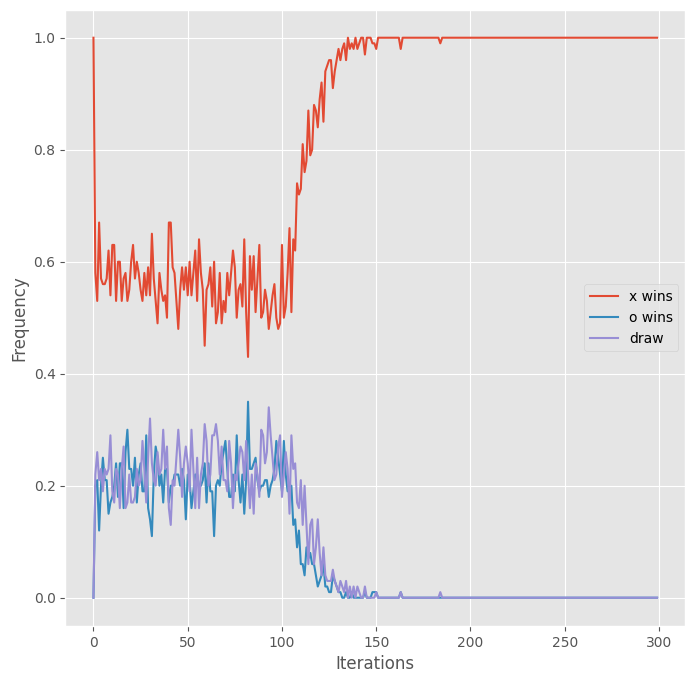

In [34]:
# Loop over games
plot_p1 = []
plot_p2 = []
plot_draw = []
N = 30000
tester = []
c1 = 0
c2 = 0
cs = 0

p1 = Player(1)
p2 = Player(-1)
debug = False
for n in tqdm(range(N)):
    # Start game
    if debug:
        print('new game')
    states = []
    p1_states = []
    p2_states = []
    board = np.zeros((3,3))
    run = 1
    p1_states.append(state_hash(board))
    states.append(state_hash(board))
    # p1 moves
    board = p1.move(board)
    p2_states.append(state_hash(board))
    states.append(state_hash(board))
    p2.updateQ(board, states)
    
    # p2 moves
    board = p2.move(board)
    p1_states.append(state_hash(board))
    states.append(state_hash(board))
    p1.updateQ(board, states)
    
    # Run rest of game
    while run:
        # p1 moves
        if debug:
            print('p1 moves')
        board = p1.move(board)
        states.append(state_hash(board))
        w = game_check(board)
        
        # Only cases are p1 win or stalemate
        if w == 1:
            tester.append(('p1', w, board.copy()))
#             print('p1')
#             print(board)
            c1 += 1
            # set rewards
            r1 = 1
            r2 = -1
            
            # p1 -> p2 -> ... -> p1 -> !p2! -> !p1! -> terminal
            p1_final_state = state_unhash(states[-2])
            a_tmp1 = np.where(board - p1_final_state != 0)
            action1 = (a_tmp1[0][0], a_tmp1[1][0])
            
            
            p2_final_state = state_unhash(states[-3])
            a_tmp2 = np.where(p1_final_state - p2_final_state != 0)
            action2 = (a_tmp2[0][0], a_tmp2[1][0])
            
            p1_idx = p1.hashes.index(state_hash(p1_final_state))
            p2_idx = p2.hashes.index(state_hash(p2_final_state))
            
            p1.Q[p1_idx][1][action1] = p1.Q[p1_idx][1][action1] + p1.a*(r1 + 0 -p1.Q[p1_idx][1][action1])
            p2.Q[p2_idx][1][action2] = p2.Q[p2_idx][1][action2] + p2.a*(r2 + 0 -p2.Q[p2_idx][1][action2])
            #p2.Q[p2_idx][1][action2] = -1
            if debug:
                print('p1 won break while loop')
            break
            
        elif w == 3:
            
            tester.append(('p1', w, board.copy()))
            if debug:
                print('p1->draw')
            # p1 made the move that resulted in stalemate, same procedure as p1 winning with indexing
            cs += 1
            r1=r2=0
#             print(p1_states)
#             print(p2_states)
            
            p1_final_state = state_unhash(states[-2])
#             print(p1_final_state)
            # Find the move that made p1 win
            a_tmp1 = np.where(board - p1_final_state != 0)
            action1 = (a_tmp1[0][0], a_tmp1[1][0])
            
            p2_final_state = state_unhash(states[-3]) # -3 since -1 would be the terminal state
            a_tmp2 = np.where(p1_final_state - p2_final_state != 0)
            action2 = (a_tmp2[0][0], a_tmp2[1][0])
#             print(p2_final_state)
            
            p1_idx = p1.hashes.index(state_hash(p1_final_state))
            p2_idx = p2.hashes.index(state_hash(p2_final_state))
            
            #print(f'move: {action1}')
            p1.Q[p1_idx][1][action1] = p1.Q[p1_idx][1][action1] + p1.a*(r1 + 0 -p1.Q[p1_idx][1][action1]) # 0 since in the terminal state there are no possible moves
            p2.Q[p2_idx][1][action2] = p2.Q[p2_idx][1][action2] + p2.a*(r2 + 0 -p2.Q[p2_idx][1][action2]) 
            if debug:
                print('p1 caused draw, break loop')
            break
        
        p2_states.append(state_hash(board))
        p2.updateQ(board, states)
            
        # p2 moves
        if debug:
            print('p2 moves')
        board = p2.move(board)
        states.append(state_hash(board))
        w = game_check(board)
    
        if w == 2:
            
            tester.append(('p2', w, board.copy()))
            if debug:
                print('p2')
                print(board)
                print(p1_states)
                print(p2_states)
            c2 += 1
            r1 = -1
            r2 = 1
            p2_final_state = state_unhash(states[-2])
            p1_final_state = state_unhash(states[-3])
            if debug:
                print(p2_final_state)
                print(p1_final_state)
            p2_idx = p2.hashes.index(state_hash(p2_final_state))
            p1_idx = p1.hashes.index(state_hash(p1_final_state))
            
            a_tmp2 = np.where(board - p2_final_state != 0)
            action2 = (a_tmp2[0][0], a_tmp2[1][0])
            a_tmp1 = np.where(p2_final_state - p1_final_state != 0)
            action1 = (a_tmp1[0][0], a_tmp1[1][0])
        
        
            
            p2.Q[p2_idx][1][action2] = p2.Q[p2_idx][1][action2] + p2.a*(r2 + 0 -p2.Q[p2_idx][1][action2]) # 0 since in the terminal state there are no possible moves
            p1.Q[p1_idx][1][action1] = p1.Q[p1_idx][1][action1] + p1.a*(r1 + 0 -p1.Q[p1_idx][1][action1]) # Maybe just set to -1
#             p1.Q[p1_idx][1][action1] = -1
            if debug:
                print(p1.Q)
                print(p2.Q)
                print('p2 won, break loop')
            break
            
        elif w == 3:
            
            tester.append(('p2', w, board.copy()))
            if debug:
                print('p2 -> draw')
            cs += 1
            r1=r2=0
            p2_final_state = state_unhash(p2_states[-2])
            p1_final_state = state_unhash(p1_states[-3])
            
            p2_idx = p2.hashes.index(state_hash(p2_final_state))
            p1_idx = p1.hashes.index(state_hash(p1_final_state))
            
            a_tmp2 = np.where(board - p2_final_state != 0)
            action2 = (a_tmp2[0][0], a_tmp2[1][0])
            a_tmp1 = np.where(p2_final_state - p1_final_state != 0)
            action1 = (a_tmp1[0][0], a_tmp1[1][0])
            
            #p2.Q[p2_idx][1][action2] = p2.Q[p2_idx][1][action2] + p2.a*(r2 + 0 -p2.Q[p2_idx][1][action2])
            #p1.Q[p1_idx][1][action1] = p1.Q[p1_idx][1][action1] + p1.a*(r1 + 0 -p1.Q[p1_idx][1][action1])
#             Q2[p2_idx][1][action2] = Q2[p2_idx][1][action2] + a*(r2 + 0 -Q2[p2_idx][1][action2]) # 0 since in the terminal state there are no possible moves
#             Q1[p1_idx][1][action1] = Q1[p1_idx][1][action1] + a*(r1 + 0 -Q1[p1_idx][1][action1]) # Maybe just set to -1
            
            break
        p1_states.append(state_hash(board))
        p1.updateQ(board, states)
    
    if n % 100 == 0:
        if n>9999:
            p1.e *= 0.9
            p2.e *= 0.9
        s = c1 + c2 + cs
        p1_frac = c1/s
        p2_frac = c2/s
        draw_frac = cs/s
        c1 = c2 = cs = 0
        #         print(f'p1:{c1/s}\np2:{c2/s}\nst:{cs/s}')
        # update e
        # Compute statistics
        plot_p1.append(p1_frac)
        plot_p2.append(p2_frac)
        plot_draw.append(draw_frac)
        
        
        
f = plt.figure(figsize=(8,8))
plt.plot(plot_p1)
plt.plot(plot_p2)
plt.plot(plot_draw)
plt.legend(['x wins', 'o wins', 'draw'])
plt.xlabel('Iterations')
plt.ylabel('Frequency')
plt.show()

In [28]:
print(tmp)

NameError: name 'tmp' is not defined

In [6]:
"""Debugging window"""
print(f'game n={n}')
print(f'length Q2 {len(p2.Q)}')
print(f'length Q1 {len(p1.Q)}')
print(f'winner {w}')
print(board)
print('')
print(f'length q2_hashes {len(p2.hashes)}')
print('')
print(f'length q1_hashes {len(p1.hashes)}')
# How the fuck do we have things in q2 and not Q2

game n=29999
length Q2 2097
length Q1 2421
winner 1
[[ 1. -1.  1.]
 [-1.  1. -1.]
 [ 1.  0.  0.]]

length q2_hashes 2097

length q1_hashes 2421


In [20]:
for element in tester:
    print(f'{element[0]} exited the game with state {element[1]}')
    print(element[2])

p2 exited the game with state 2
[[-1.  0.  1.]
 [ 1. -1.  0.]
 [ 0.  1. -1.]]
p2 exited the game with state 2
[[-1.  0.  1.]
 [-1.  1. -1.]
 [-1.  1.  1.]]
p1 exited the game with state 3
[[-1.  1.  1.]
 [ 1. -1. -1.]
 [ 1. -1.  1.]]
p2 exited the game with state 2
[[-1. -1. -1.]
 [ 0.  0.  1.]
 [ 1.  0.  1.]]
p1 exited the game with state 3
[[ 1. -1. -1.]
 [-1.  1.  1.]
 [ 1.  1. -1.]]
p1 exited the game with state 1
[[ 1. -1. -1.]
 [-1.  1. -1.]
 [ 1.  1.  1.]]
p1 exited the game with state 1
[[ 1.  1.  1.]
 [ 1. -1. -1.]
 [-1. -1.  1.]]
p1 exited the game with state 1
[[-1.  1.  1.]
 [-1. -1.  1.]
 [ 1. -1.  1.]]
p2 exited the game with state 2
[[-1.  1.  1.]
 [ 1. -1.  1.]
 [-1.  0. -1.]]
p1 exited the game with state 1
[[ 1.  0.  0.]
 [ 0.  1. -1.]
 [ 0. -1.  1.]]
p1 exited the game with state 1
[[ 1. -1.  1.]
 [ 1.  1. -1.]
 [-1. -1.  1.]]
p1 exited the game with state 1
[[ 0.  1. -1.]
 [ 0.  1.  0.]
 [-1.  1.  0.]]
p1 exited the game with state 1
[[ 1.  1.  1.]
 [-1. -1.  0.]
 [

[[ 1.  1. -1.]
 [-1. -1.  1.]
 [ 1.  1. -1.]]
p1 exited the game with state 3
[[-1.  1. -1.]
 [ 1. -1.  1.]
 [ 1. -1.  1.]]
p2 exited the game with state 2
[[-1. -1.  0.]
 [ 1. -1.  1.]
 [ 1.  1. -1.]]
p2 exited the game with state 2
[[-1.  0.  1.]
 [-1.  1.  1.]
 [-1.  1. -1.]]
p1 exited the game with state 1
[[ 1.  1. -1.]
 [ 1. -1. -1.]
 [ 1. -1.  1.]]
p1 exited the game with state 1
[[-1. -1.  1.]
 [ 1.  1. -1.]
 [ 1.  1. -1.]]
p1 exited the game with state 1
[[-1.  0.  1.]
 [-1.  0. -1.]
 [ 1.  1.  1.]]
p2 exited the game with state 2
[[ 1.  0. -1.]
 [ 0.  0. -1.]
 [ 1.  1. -1.]]
p2 exited the game with state 2
[[-1.  1. -1.]
 [-1.  0.  1.]
 [-1.  1.  1.]]
p1 exited the game with state 1
[[ 0. -1. -1.]
 [ 0.  1. -1.]
 [ 1.  1.  1.]]
p2 exited the game with state 2
[[-1.  1.  1.]
 [ 0. -1.  1.]
 [-1.  1. -1.]]
p1 exited the game with state 3
[[-1.  1.  1.]
 [ 1.  1. -1.]
 [-1. -1.  1.]]
p2 exited the game with state 2
[[ 1.  0.  1.]
 [ 1.  0.  0.]
 [-1. -1. -1.]]
p2 exited the game

[[ 0.  0.  1.]
 [ 0. -1.  1.]
 [ 0. -1.  1.]]
p2 exited the game with state 2
[[-1. -1. -1.]
 [-1.  1.  1.]
 [ 0.  1.  1.]]
p2 exited the game with state 2
[[ 1. -1. -1.]
 [ 1. -1.  0.]
 [-1.  1.  1.]]
p1 exited the game with state 1
[[-1.  1. -1.]
 [ 0.  0. -1.]
 [ 1.  1.  1.]]
p1 exited the game with state 1
[[-1.  1.  1.]
 [-1.  1.  1.]
 [ 1. -1. -1.]]
p1 exited the game with state 1
[[ 1. -1.  0.]
 [ 0.  1.  0.]
 [-1.  0.  1.]]
p1 exited the game with state 1
[[ 0.  0.  1.]
 [-1.  1. -1.]
 [ 1.  0.  0.]]
p1 exited the game with state 1
[[-1.  1. -1.]
 [-1.  1. -1.]
 [ 1.  1.  1.]]
p1 exited the game with state 1
[[ 1. -1. -1.]
 [-1.  1.  1.]
 [ 1. -1.  1.]]
p2 exited the game with state 2
[[-1.  1.  0.]
 [ 1. -1.  0.]
 [ 1.  0. -1.]]
p2 exited the game with state 2
[[ 0.  0. -1.]
 [ 0.  1. -1.]
 [ 1.  1. -1.]]
p2 exited the game with state 2
[[-1.  1. -1.]
 [ 0. -1.  1.]
 [-1.  1.  1.]]
p1 exited the game with state 3
[[-1.  1. -1.]
 [ 1. -1.  1.]
 [ 1. -1.  1.]]
p1 exited the game

[[ 1. -1.  0.]
 [ 1. -1. -1.]
 [ 1.  0.  1.]]
p1 exited the game with state 1
[[-1.  0.  1.]
 [ 0.  1. -1.]
 [ 1.  1. -1.]]
p2 exited the game with state 2
[[-1.  1.  1.]
 [ 1.  0.  1.]
 [-1. -1. -1.]]
p2 exited the game with state 2
[[ 0.  0.  1.]
 [-1. -1. -1.]
 [ 0.  1.  1.]]
p1 exited the game with state 1
[[ 0.  0.  1.]
 [ 1.  1. -1.]
 [ 1. -1. -1.]]
p1 exited the game with state 1
[[ 0.  0.  0.]
 [-1.  0. -1.]
 [ 1.  1.  1.]]
p1 exited the game with state 1
[[-1.  0.  1.]
 [-1.  1.  0.]
 [ 1.  0.  0.]]
p2 exited the game with state 2
[[ 1.  0. -1.]
 [-1.  1. -1.]
 [ 1.  1. -1.]]
p2 exited the game with state 2
[[ 1.  1. -1.]
 [ 1.  1. -1.]
 [ 0. -1. -1.]]
p2 exited the game with state 2
[[ 0. -1.  0.]
 [ 1. -1.  1.]
 [ 0. -1.  1.]]
p1 exited the game with state 1
[[-1.  1. -1.]
 [-1.  1.  1.]
 [ 1.  1. -1.]]
p1 exited the game with state 1
[[ 0.  1.  0.]
 [ 0.  1. -1.]
 [-1.  1.  0.]]
p1 exited the game with state 3
[[-1.  1.  1.]
 [ 1.  1. -1.]
 [-1. -1.  1.]]
p1 exited the game

[[ 1. -1.  1.]
 [-1.  1. -1.]
 [ 1.  1. -1.]]
p1 exited the game with state 1
[[ 0.  1. -1.]
 [-1.  1.  0.]
 [ 1.  1. -1.]]
p2 exited the game with state 2
[[-1.  1.  1.]
 [ 1. -1. -1.]
 [ 1.  0. -1.]]
p1 exited the game with state 1
[[ 0. -1. -1.]
 [ 1.  1.  1.]
 [-1.  0.  1.]]
p1 exited the game with state 1
[[-1.  1. -1.]
 [ 0. -1.  0.]
 [ 1.  1.  1.]]
p1 exited the game with state 1
[[ 1.  1. -1.]
 [ 0.  1.  0.]
 [-1.  1. -1.]]
p1 exited the game with state 1
[[ 1. -1.  0.]
 [ 0.  1.  0.]
 [-1.  0.  1.]]
p1 exited the game with state 1
[[ 1.  0.  1.]
 [-1.  1. -1.]
 [-1.  0.  1.]]
p1 exited the game with state 1
[[ 1. -1.  1.]
 [ 1. -1. -1.]
 [ 1.  1. -1.]]
p1 exited the game with state 1
[[ 1.  1.  1.]
 [ 0.  0.  0.]
 [-1. -1.  0.]]
p2 exited the game with state 2
[[-1. -1. -1.]
 [ 0.  1.  1.]
 [ 1.  0.  0.]]
p1 exited the game with state 1
[[ 1.  1.  1.]
 [ 1. -1. -1.]
 [-1. -1.  1.]]
p2 exited the game with state 2
[[ 0.  1. -1.]
 [ 1. -1. -1.]
 [ 1.  1. -1.]]
p1 exited the game

In [15]:
a = np.zeros((3,3))
print(game_check(a))
a[1,:] = -1
print(game_check(a))
a[1,:] = 1
print(game_check(a))
a[1,:] = 0
print(game_check(a))
a[0,0] = 1
a[1,1] = 1
a[2,2] = 1
print(game_check(a))
a[0,0] = -1
a[0,1] = -1
a[0,2] = 1
a[1,0] = 1
a[1,2] = -1
a[2,0] = -1
a[2,1] = 1
print(a)
print(game_check(a))

0
2
1
0
1
[[-1. -1.  1.]
 [ 1.  1. -1.]
 [-1.  1.  1.]]
3


In [6]:
ct = c1 + c2 + cs
print(f'p1: {c1}/{ct}\np2: {c2}/{ct}\ndraw: {cs}/{ct}')

p1: 1/4
p2: 3/4
draw: 0/4


In [16]:
for element in p2.Q:
    print(element[0])
    print('')
    print(element[1])
    print('')
    print('------------------')
print('PLAYER 1')
for element in p1.Q:
    print(element[0])
    print('')
    print(element[1])
    print('')
    print('------------------')

[[1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

[[nan  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]

------------------
[[ 1.  0.  0.]
 [ 0.  1. -1.]
 [ 0.  0.  0.]]

[[ nan  0.   0. ]
 [ 0.   nan  nan]
 [-0.1  0.   0. ]]

------------------
[[ 1.  1.  0.]
 [ 0.  0.  0.]
 [-1.  0.  0.]]

[[ nan  nan  0. ]
 [ 0.  -0.1  0. ]
 [ nan  0.   0. ]]

------------------
[[ 1.  0.  0.]
 [ 0.  0.  0.]
 [ 1.  0. -1.]]

[[nan  0.  0.]
 [ 0.  0.  0.]
 [nan  0. nan]]

------------------
[[ 1.  0.  0.]
 [ 0. -1.  1.]
 [ 1.  0. -1.]]

[[nan  0.  0.]
 [ 0. nan nan]
 [nan  0. nan]]

------------------
[[ 1.  0.  1.]
 [-1. -1.  1.]
 [ 1.  0. -1.]]

[[nan  0. nan]
 [nan nan nan]
 [nan  0. nan]]

------------------
[[ 1. -1.  1.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]

[[nan nan nan]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]

------------------
[[ 1. -1.  1.]
 [-1.  0.  0.]
 [ 0.  0.  1.]]

[[  nan   nan   nan]
 [  nan -0.19  0.  ]
 [ 0.    0.     nan]]

------------------
[[0. 1. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

[[ 0. nan  0.]
 [ 0.  0.  0.]
 

In [8]:
for i in range(1000):
    print('p1')
    print(p1.Q[i])
    print(p1.Q[i][1])
    print('')
    print('p20')
    print(p2.Q[i])
    print(p2.Q[i][1])
    print('')

p1
[array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

p20
[array([[0., 0., 0.],
       [1., 0., 0.],
       [0., 0., 0.]]), array([[ 0.,  0.,  0.],
       [nan,  0.,  0.],
       [ 0.,  0.,  0.]])]
[[ 0.  0.  0.]
 [nan  0.  0.]
 [ 0.  0.  0.]]

p1
[array([[ 0., -1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  0.]]), array([[ 0., nan,  0.],
       [nan,  0.,  0.],
       [ 0.,  0.,  0.]])]
[[ 0. nan  0.]
 [nan  0.  0.]
 [ 0.  0.  0.]]

p20
[array([[ 1., -1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  0.]]), array([[nan, nan,  0.],
       [nan,  0.,  0.],
       [ 0.,  0.,  0.]])]
[[nan nan  0.]
 [nan  0.  0.]
 [ 0.  0.  0.]]

p1
[array([[ 1., -1., -1.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  0.]]), array([[nan, nan, nan],
       [nan,  0.,  0.],
       [ 0.,  0.,  0.]])]
[[nan nan nan]
 [nan  0.  0.]
 [ 0.  0.  0.]]

p20
[array([[ 1., -1., -1.],
       [ 1

IndexError: list index out of range

In [ ]:
print(Q)